# Safety Recommenders Project:


# Project Description

The objective of the project is create a data product that helps people that are traveling to Washington DC to determine how safe are the most popular places in the city.



## Dataset Description

This Project will use two datasets. The first dataset is a csv file that contains all the crimes that have ocurred in the past two and a half years around Washington DC. This dataset does not contain information about locations where there was no crime.
The secon dataset is a csv file that contains all the adresses in Washington DC. The main use of this dataset is to use in conjunction with the first file in order determine location where no crime occurred.

Finally after the first analyses, some of the features of the crime dataset will be removed to make the dataproduct simpler to use. Features like date, time, location and adress will be kept, and features like offense type and location codes used by the police department will also be removed.

### Importing Necesary Libraries:

In [22]:
%matplotlib notebook
import IPython
from IPython.display import display
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import pandas as pd
import csv
from numpy import nan as NA
from datetime import datetime
import re
import sys
import numpy as np
import matplotlib.pyplot as plt 
import scipy as sp
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from pandas import *
import pickle

### Data Ingestion:

Here We are creating the module that will take care of our csv file. One class is designed to deal with csv files and the other class to deal with a postgres database.

In [23]:
class Ingestion(object):
    """This is the ingestion class to deal with csv directly from the same directory where the module is"""

    def __init__(self, file, sep = ",", header = 0 ):
        self.file = file
        self.delimiter = sep
        self.df = pd.read_csv(file, sep= sep, header=header, engine='python')

    def file_csv(self):
        return self.df

class IngestionDatabase(object):

    """ This is the ingestion class to deal with postgress database """
    def __init__(self, database, query):
        self.engine = create_engine(database)
        self.table_names = self.engine.table_names()
        self.con = self.engine.connect()
        self.rs = self.con.execute(query)
        self.df = pd.DataFrame(self.rs.fetchmany(size=15))

    def cols(self):
        self.df.columns = self.rs.keys()
        return self.df


#### Creating the Ingestion instances and exploring the raw dataset:

In [24]:
ingest = Ingestion('DC_Crime_Official.csv')
data = ingest.file_csv()

In [25]:
with open('file1.pickle', 'wb') as object1:
    
    pickle.dump([ingest,data] , object1)

Loading the objects(only use when running time is decreased)!!

In [26]:
with open('file1.pickle', 'rb') as objects:
    
    object_list = pickle.load(objects)
    
data = object_list[1]

In [27]:
data.head(2)

,neighborhood_cluster,census_tract,offense_group,longitude,end_date,offense_text,shift,yblock,district,ward,...,xblock,block,start_date,cnn,offense,anc,report_date,method,location,latitude
0,cluster 32,7708.0,property,-76.955521,2016-10-04T16:37:29.000,motor vehicle theft,evening,135396.0,6.0,7,...,403859.0,3500 - 3526 block of minnesota avenue se,2016-10-04T16:09:08.000,16168699,motor vehicle theft,7B,2016-10-05T03:00:47.000Z,others,"38.886402972929169,-76.955523453842957",38.886395
1,cluster 4,100.0,property,-77.059614,2016-10-04T17:44:13.000,theft/other,evening,137194.0,2.0,2,...,394829.0,3000 - 3029 block of k street nw,2016-10-04T17:00:48.000,16168738,theft/other,2E,2016-10-05T01:36:11.000Z,others,"38.902593275715809,-77.059616752356732",38.902585


### Initial Data Wrangling of Crime Dataset

In [28]:
class Wrangling(object):

    def __init__(self, data = data):
        self.df = data
# drop empty rows
    def dropNA(self):
        self.df = self.df.dropna(how='all') # this only drop rows with 100% NA
        return self.df

    def __offense_column(self, text1 ='theft/other', text2 ='theft f/auto', text3 = 'assault w/dangerous weapon',
                       repl1 = 'theft', repl2 = 'auto theft', repl3 = 'assault with weapon' ):

        """There are 9 categories of offenses here:
        This function will transform the caterogies into more readable text
        for example : assault w/dangerous weapon = assault with dangerous weapon"""

        self.df['offense_text'] = self.df['offense_text'].replace([text1, text2, # add the column name to the arguments.
        text3], [repl1, repl2, repl3])
        return self.df

    def date_time_transformer(self, time = 'start_date', second_date = 'report_date', third_date = 'end_date'):
        ''' transform into datetime 64 object and eliminate the second date column'''
        self.df[time] = pd.to_datetime(self.df['start_date'])
        self.df.drop([second_date, third_date], axis = 1, inplace = True)
        return self.df

    def __latlong_cutter(self):
        """ Reduce the presition of the lat long data by cutting them."""
        self.newlat = []
        self.newlon = []
        for item in self.df['latitude']:
            item = str(item)
            item = float(item[0:6])
            self.newlat.append(item)

        self.df['latitude'] = self.newlat

        for item in self.df['longitude']:
            item = str(item)
            item = float(item[0:7])
            self.newlon.append(item)
        self.df['longitude'] = self.newlon

        return self.df

    def lat_long_rounder(self, decimals = 3):
        """ Reduce the presition of the lat long data by rounging decimals"""
        self.df['latitude'] = self.df['latitude'].round(decimals = decimals)
        self.df['longitude'] = self.df['longitude'].round(decimals = decimals)
        return self.df

    def adress_format_modifier(self):
        """This columns replace some of the content from the block columns to it is easy to parse it"""

        self.splitted = []

        # creating the splited column
        # this is working. it cannot be transformed into pandas' .replace because it is using the split method
        # Note that the built in .replace it does not work properly with integers and neither with large amounts of
        # things to change.. This works but it is not very wise to use.
        for row in self.df['block']:
            row = row.replace("block of ", "")
            row = row.replace("street", "St")
            row = row.replace("-", "")
            row = row.split(' ', 1)
            self.splitted.append(row)
        self.df['splitted'] = self.splitted
        return self.df

    def block_parser(self):
        """ This is the block parser that separate block in start and en blocks"""

        self.startblock = []
        self.endblock_1 = []
        self.endblock = []
        #  create column 'startblock'
        for row in self.df['splitted']:
            row = row[0]
            self.startblock.append(row)
        self.df['startblock'] = self.startblock
        # create column  'endblock_1'
        for row in self.df['splitted']:
            row = row[-1].lstrip() # enblock_1
            row = row.split(' ',1)
            self.endblock_1.append(row)
        self.df['endblock_1'] = self.endblock_1
        # create column  'endblock'
        for row in self.df['endblock_1']:
            row = row[0]
            self.endblock.append(row)
        self.df['endblock'] = self.endblock
        return self.df

    def street_parser(self):
        self.street = []
        #creating column 'street'
        for row in self.df['endblock_1']:
            row = row[1]
            self.street.append(row)
        self.df['street'] = self.street
        return self.df

Creating the wrangling instances:

In [29]:
Wrangled = Wrangling()
Wrangled.dropNA()
Wrangled.date_time_transformer()
Wrangled.lat_long_rounder()
Wrangled.adress_format_modifier()
Wrangled.block_parser()
df = Wrangled.street_parser()

In [30]:
with open('file2.pickle', 'wb') as object2:
    
    pickle.dump(df , object2)

Loading the objects(only use when running time is decreased)!!

In [31]:
with open('file2.pickle', 'rb') as objects2:
    
    object_ = pickle.load(objects2)
    
df = object_

Dropping repeated columns created during the first wrangling process:

In [32]:
df = df.drop(columns = ['location', 'endblock_1', 'splitted'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69204 entries, 0 to 69203
Data columns (total 28 columns):
neighborhood_cluster    68431 non-null object
census_tract            69051 non-null float64
offense_group           69204 non-null object
longitude               69204 non-null float64
offense_text            69204 non-null object
shift                   69204 non-null object
yblock                  69204 non-null float64
district                69181 non-null float64
ward                    69204 non-null int64
year                    69204 non-null int64
offense_key             69204 non-null object
bid                     12302 non-null object
sector                  69175 non-null object
psa                     69175 non-null float64
ucrrank                 69204 non-null int64
block_group             69051 non-null object
voting_precinct         69204 non-null object
xblock                  69204 non-null float64
block                   69204 non-null object
start_date    

In [33]:
from datetime import datetime
df["start_date"] = pd.to_datetime(df["start_date"])
df["year"] =df["start_date"].dt.year
df["month"] =df["start_date"].dt.month
df["day"] =df["start_date"].dt.day
df["hour"] =df["start_date"].dt.hour
df["minute"] =df["start_date"].dt.minute
df["second"] =df["start_date"].dt.second


# Now, Eliminate the start_date column.
df = df.drop(columns = 'start_date') 

## Exploration of the dataset and preparation of the dataset for Predictions:

### Description of the dataset:

In [34]:
df.describe()

,census_tract,longitude,yblock,district,ward,year,psa,ucrrank,xblock,cnn,latitude,month,day,hour,minute,second
count,69051.000000,69204.000000,69204.000000,69181.000000,69204.000000,69204.000000,69175.000000,69204.000000,69204.000000,6.920400e+04,69204.000000,69204.000000,69204.000000,69204.000000,69204.000000,69204.000000
mean,6237.865158,-77.007872,137642.604197,3.664445,4.410439,2016.702980,370.995909,6.052829,399320.139603,1.684337e+07,38.906646,6.690986,15.988267,13.566485,21.684411,28.880975
std,3108.028110,0.035919,3356.217001,1.952458,2.343418,1.047212,195.065156,1.300921,3114.574120,7.433765e+05,0.030235,3.369582,8.738579,6.270927,18.715592,17.673335
min,100.000000,-77.114000,127300.000000,1.000000,1.000000,1916.000000,101.000000,1.000000,390147.000000,2.111617e+06,38.813000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,3600.000000,-77.031000,136128.000000,2.000000,2.000000,2016.000000,206.000000,6.000000,397293.000000,1.616618e+07,38.893000,4.000000,9.000000,10.000000,0.000000,14.000000
50%,6900.000000,-77.013000,137617.000000,3.000000,5.000000,2017.000000,308.000000,6.000000,398877.000000,1.704685e+07,38.906000,7.000000,16.000000,14.000000,21.000000,29.000000
75%,8904.000000,-76.986000,139592.000000,5.000000,6.000000,2017.000000,506.000000,7.000000,401257.000000,1.716980e+07,38.924000,10.000000,23.000000,19.000000,36.000000,44.000000
max,11100.000000,-76.910000,147292.000000,7.000000,8.000000,2018.000000,708.000000,9.000000,407806.000000,8.501717e+07,38.994000,12.000000,31.000000,23.000000,59.000000,59.000000


### Preparing X and y sets. Dropping Remaining na values:


In [35]:
df = df.dropna()

X = df.drop(columns = ['ucrrank'])

y = df['ucrrank']

### Encoding the Categorical variables: 

In [36]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder() # it only support one dimentional columns.. 

for colname,col in X.iteritems(): # adapted from stack overflow
    if col is not float:
        X[colname] = LabelEncoder().fit_transform(col)

### Studying  the importance of the features using principal component analysis:



In [37]:
X.columns

Index(['neighborhood_cluster', 'census_tract', 'offense_group', 'longitude',
       'offense_text', 'shift', 'yblock', 'district', 'ward', 'year',
       'offense_key', 'bid', 'sector', 'psa', 'block_group', 'voting_precinct',
       'xblock', 'block', 'cnn', 'offense', 'anc', 'method', 'latitude',
       'startblock', 'endblock', 'street', 'month', 'day', 'hour', 'minute',
       'second'],
      dtype='object')

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10) # input a number for feature extraction

features = X

X_ = pca.fit_transform(features)

explained_var = pca.explained_variance_ratio_
explained_var


array([9.91642087e-01, 4.94433830e-03, 2.38423964e-03, 5.12625077e-04,
       2.64671778e-04, 1.40986881e-04, 3.34202131e-05, 2.83237958e-05,
       2.59191796e-05, 6.32297071e-06])

It can be appreciated here that there is one variable that explains most of the variability of the dataset. 

<IPython.core.display.Javascript object>


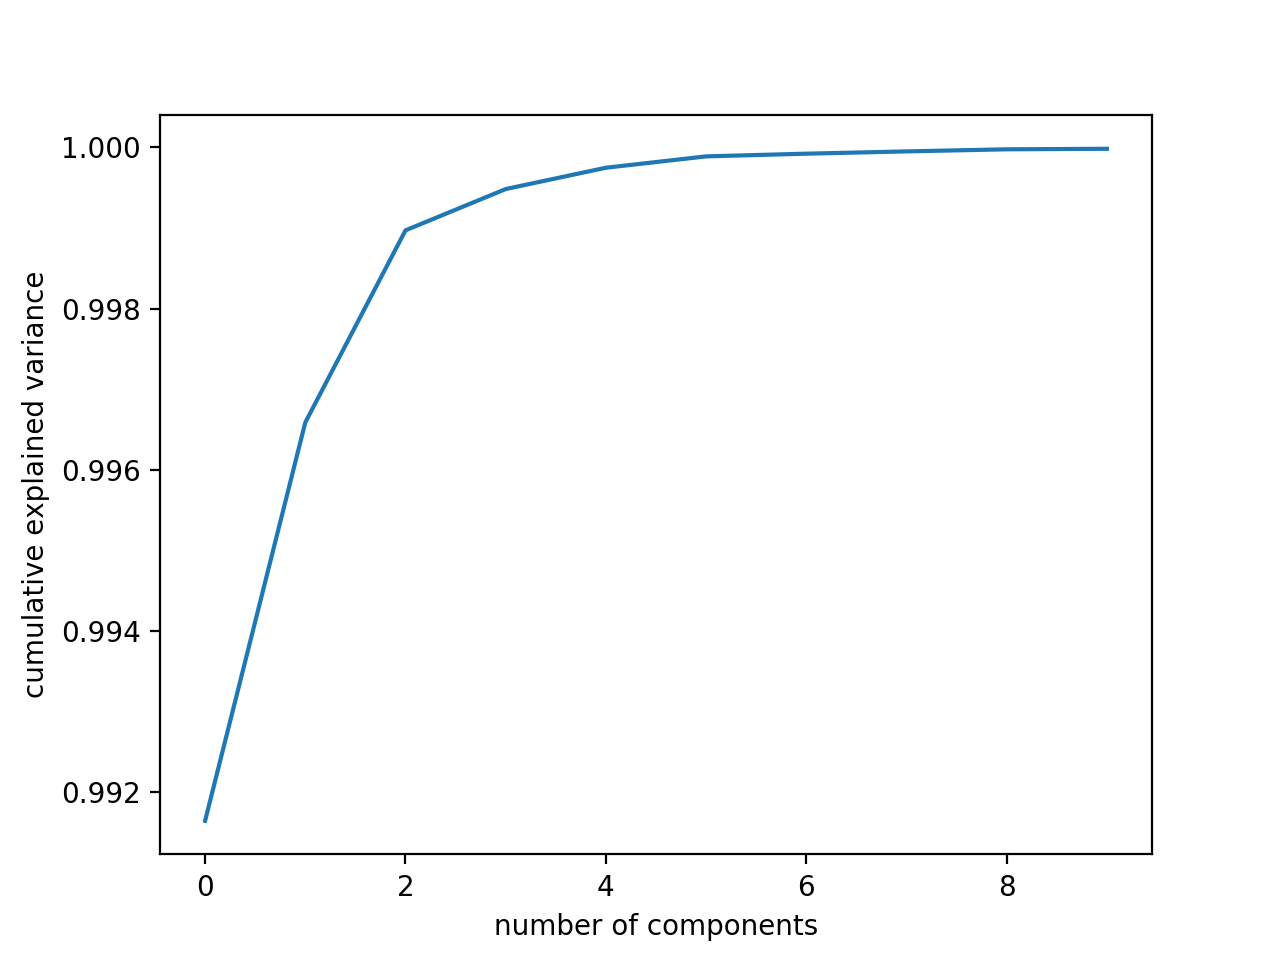

In [39]:

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Creating the Training and test set:

In [40]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 0)

## Visual Exploration

<IPython.core.display.Javascript object>


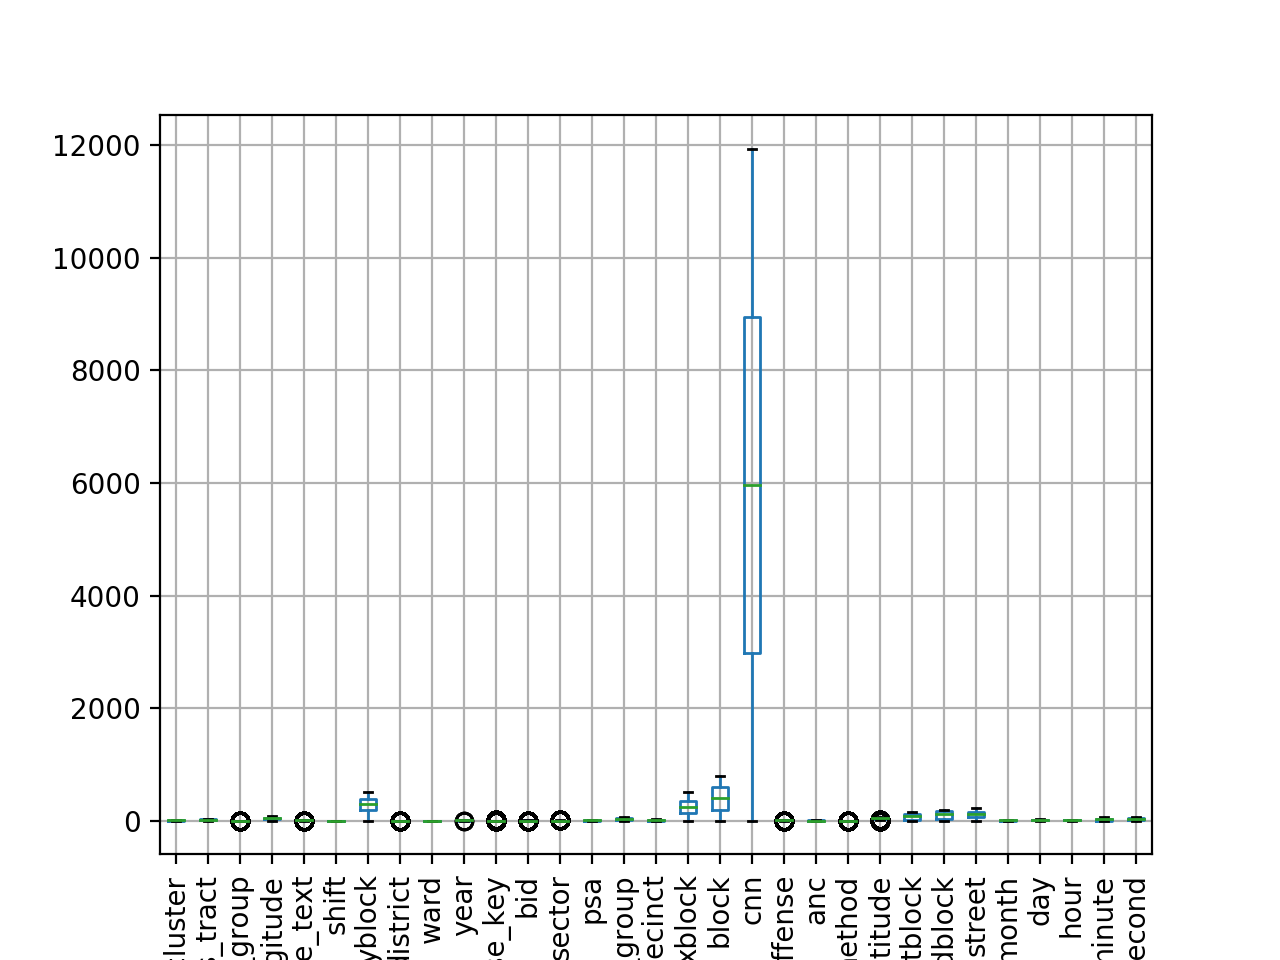

In [41]:

cols = pd.DataFrame(features)
cols = list(cols.columns)

boxplot = X.boxplot(column=cols, rot=90, fontsize=10)

As it can be appreciated here, there is one variable that has the greatest variability. Since we do not now what that means, it will be temporary eliminated in order to study the dispersion of the other features

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10) # input a number for feature extraction

features2 = X.drop(columns = 'cnn')

X_ = pca.fit_transform(features)

explained_var = pca.explained_variance_ratio_
explained_var

array([9.91642087e-01, 4.94433830e-03, 2.38423964e-03, 5.12625077e-04,
       2.64671778e-04, 1.40986881e-04, 3.34202131e-05, 2.83237958e-05,
       2.59191796e-05, 6.32297071e-06])

<IPython.core.display.Javascript object>


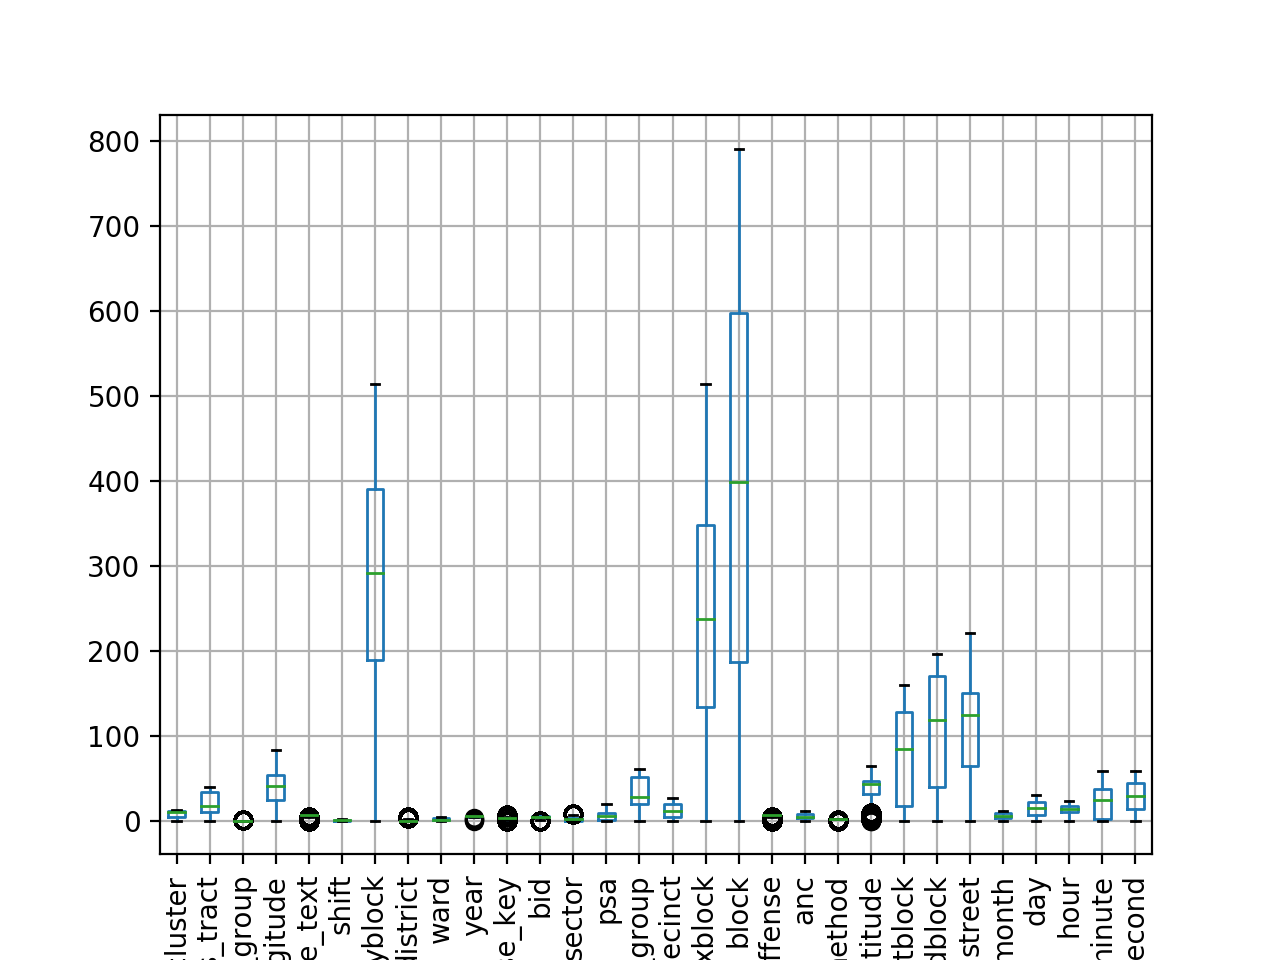

In [43]:
cols2 = pd.DataFrame(features2)
cols2 = list(cols2.columns)

boxplot = X.boxplot(column=cols2, rot=90, fontsize=10)

We can see here that location present the greatest dispersion of data. I the last section we well select from the dataframe only the features that can be easily provided by the user: time, street lat, long, etc.

### Standarization of the dataset:
Since this two graphs shows that there is a great dispersion of the data. They will be standarized:


In [44]:
scaler = StandardScaler()
#scaler =  MinMaxScaler()
#scaler = Normalizer()
X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.fit(X_test).transform(X_test)

Transforming the y labels into numpy arrays to increase computation performance:

In [45]:
y_train = y_train.values
y_test = y_test.values



<IPython.core.display.Javascript object>


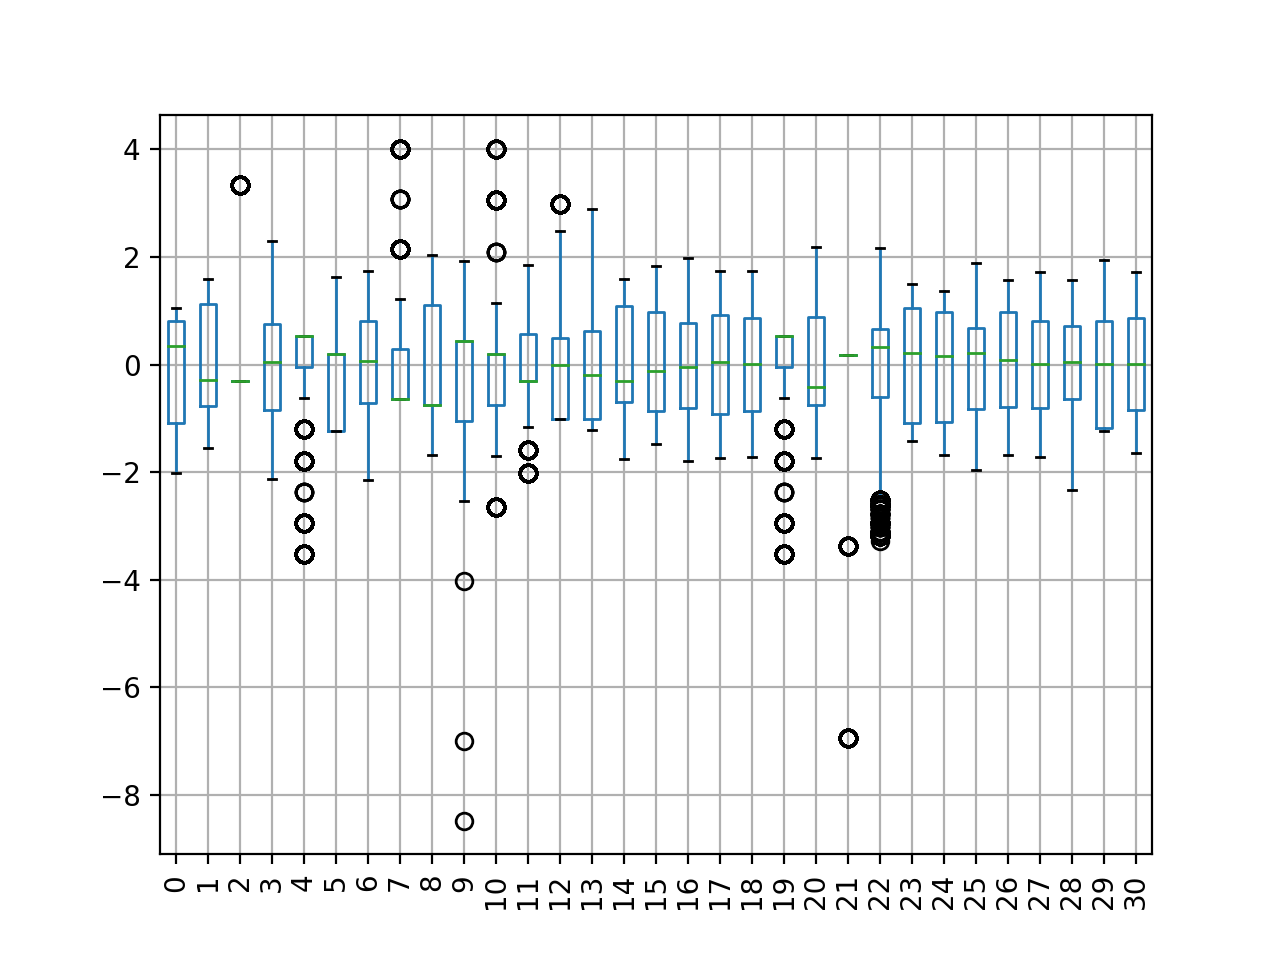

In [46]:
cols = pd.DataFrame(features)
cols = list(cols.columns)
X_train_df = pd.DataFrame(X_train)
boxplot = X_train_df.boxplot( rot=90, fontsize=10)


Now all the features have been standarized.

# Fitting models and performing predictions over the crime dataset:



### KNN:

In [47]:
knn = KNeighborsClassifier(n_neighbors = 10, metric = 'manhattan', weights = 'uniform', algorithm = 'auto')
knn.fit(X_train, y_train)
predicted_knn = knn.predict(X_test)
print("Predictions: {}".format(predicted_knn))

Predictions: [6 7 6 ... 6 6 7]


Cross Validation:

In [49]:
scores = cross_val_score(knn, X = X_train, y = y_train)
print ("Cross Validation Scores: {}".format(scores))

Cross Validation Scores: [0.92529818 0.92870603 0.92866122]


In [50]:
report = classification_report(y_test, predicted_knn)
print (report)

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       1.00      0.13      0.24        15
          3       0.99      0.99      0.99        77
          4       0.88      0.99      0.93       103
          5       0.97      0.90      0.93        70
          6       0.94      0.99      0.96      1438
          7       0.92      0.84      0.88       591
          8       0.91      0.67      0.77        93

avg / total       0.93      0.93      0.93      2389



/home/franco/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Finding the best parameters for Knn
In this case, gridsearchCV and a simple loop will be used in order to find the optimal hyperparameters for KNN

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

params2 = [{'n_neighbors': [1,10,50,100], 'algorithm': ['auto','ball_tree','kd_tree' ], 
            'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'manhattan']}]
            
grid_search = GridSearchCV(estimator = knn, param_grid = params2, scoring = 'accuracy', cv = 5, n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
accuracy = grid_search.best_score_
best_params = grid_search.best_params_

In [53]:
print(accuracy)
print(best_params)

0.9474455611390284
{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


In [55]:
knn = [params2, grid_search, accuracy, best_params]
with open('file3.pickle', 'wb') as object3:
    pickle.dump(knn , object3)

Loading the objects(to avoid recalculations)!!

In [56]:
with open('file3.pickle', 'rb') as objects3:
    
    knn_obj = pickle.load(objects3)
    
knn_obj

[[{'n_neighbors': [1, 10, 50, 100],
   'algorithm': ['auto', 'ball_tree', 'kd_tree'],
   'weights': ['uniform', 'distance'],
   'metric': ['minkowski', 'manhattan']}],
 GridSearchCV(cv=5, error_score='raise',
        estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
            metric_params=None, n_jobs=1, n_neighbors=10, p=2,
            weights='uniform'),
        fit_params=None, iid=True, n_jobs=-1,
        param_grid=[{'n_neighbors': [1, 10, 50, 100], 'algorithm': ['auto', 'ball_tree', 'kd_tree'], 'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'manhattan']}],
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring='accuracy', verbose=0),
 0.9474455611390284,
 {'algorithm': 'auto',
  'metric': 'manhattan',
  'n_neighbors': 10,
  'weights': 'distance'}]

<IPython.core.display.Javascript object>


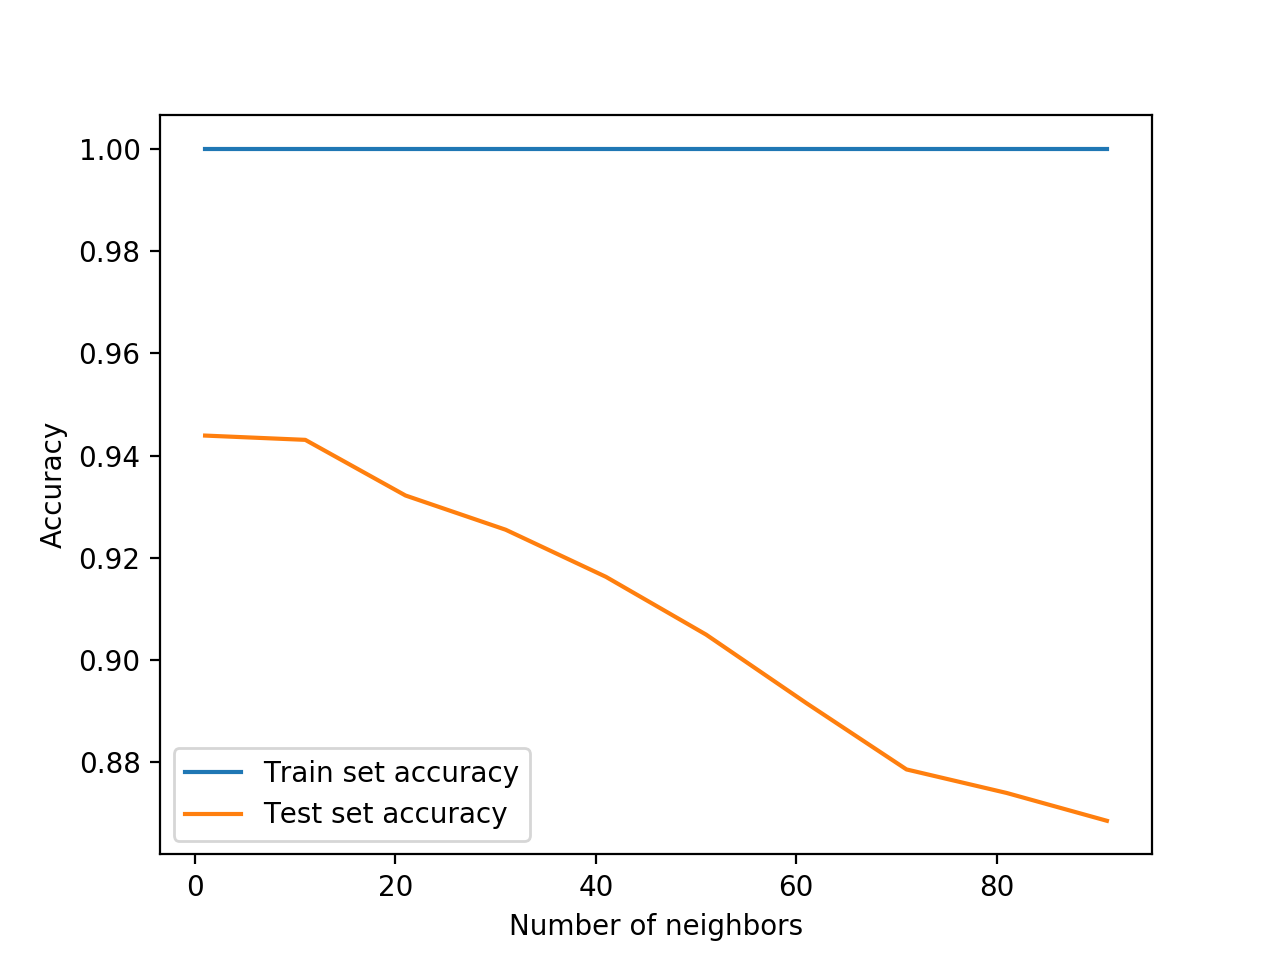

In [58]:
train_accuracy = []
test_accuracy = []

neighbors = range(1,100,10)
algorithms = ['auto', 'ball_tree', 'kd_tree']
weights = ['uniform', 'distance']

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors = i, metric = 'manhattan', weights = 'distance', algorithm = 'auto')
    knn.fit(X_train, y_train)
    train_accuracy.append(knn.score(X_train, y_train))
    test_accuracy.append(knn.score(X_test, y_test))
figure1 = plt.plot(neighbors, train_accuracy, label = 'Train set accuracy')
figure2 = plt.plot(neighbors, test_accuracy, label = 'Test set accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Number of neighbors")
plt.legend()
plt.show()

In [59]:
fig = [figure1, figure2]
with open('figure1.pickle', 'wb') as figure:
    pickle.dump(fig , figure)

Loading the objects(to avoid recalculations)!!

In [ ]:
with open('figure1.pickle', 'rb') as figures:
    
    figs = pickle.load(figures)
    
figs

For this model, the level of accuracy is very high. It will probably be possible to increaset even more using other models.

## Kernel SVC:

In [62]:
from sklearn.svm import SVC
svm = SVC(C = 1000, kernel = 'rbf', gamma = 1)
svm.fit(X_train, y_train)
predicted = svm.predict(X_test)

#print("Predictions: {}".format(predicted))

scores = cross_val_score(svm, X = X_train, y = y_train)
report = classification_report(y_test, predicted)
print (report)

# print ("Cross Validation Scores: {}".format(scores))

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.00      0.00      0.00        15
          3       1.00      0.01      0.03        77
          4       1.00      0.01      0.02       103
          5       0.00      0.00      0.00        70
          6       0.63      1.00      0.77      1438
          7       1.00      0.16      0.27       591
          8       1.00      0.01      0.02        93

avg / total       0.74      0.64      0.53      2389



/home/franco/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
ksvc = [svm, predicted, scores, report]
with open('file4.pickle', 'wb') as object4:
    pickle.dump(ksvc , object4)

In [ ]:
with open('file4.pickle', 'rb') as objects4:
    
    Ksvc = pickle.load(objects4)
    
print(Ksvc[-1])

### Finding the best parameters for Kernel SVC:

In [66]:
params = [{'C': [1, 10, 30, 100], 'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 0.001]}]
     
                          
grid_search = GridSearchCV(estimator = svm, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
accuracySVC = grid_search.best_score_
best_paramsSVC = grid_search.best_params_

In [67]:
print(accuracySVC)
print(best_paramsSVC)

0.9998953098827471
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [68]:
params = [grid_search, accuracySVC, best_paramsSVC]
with open('file5.pickle', 'wb') as object5:
    pickle.dump(params , object5)

In [69]:
with open('file5.pickle', 'rb') as objects5:
    
    best_params = pickle.load(objects5)
    
print(best_params[-1])

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


<IPython.core.display.Javascript object>


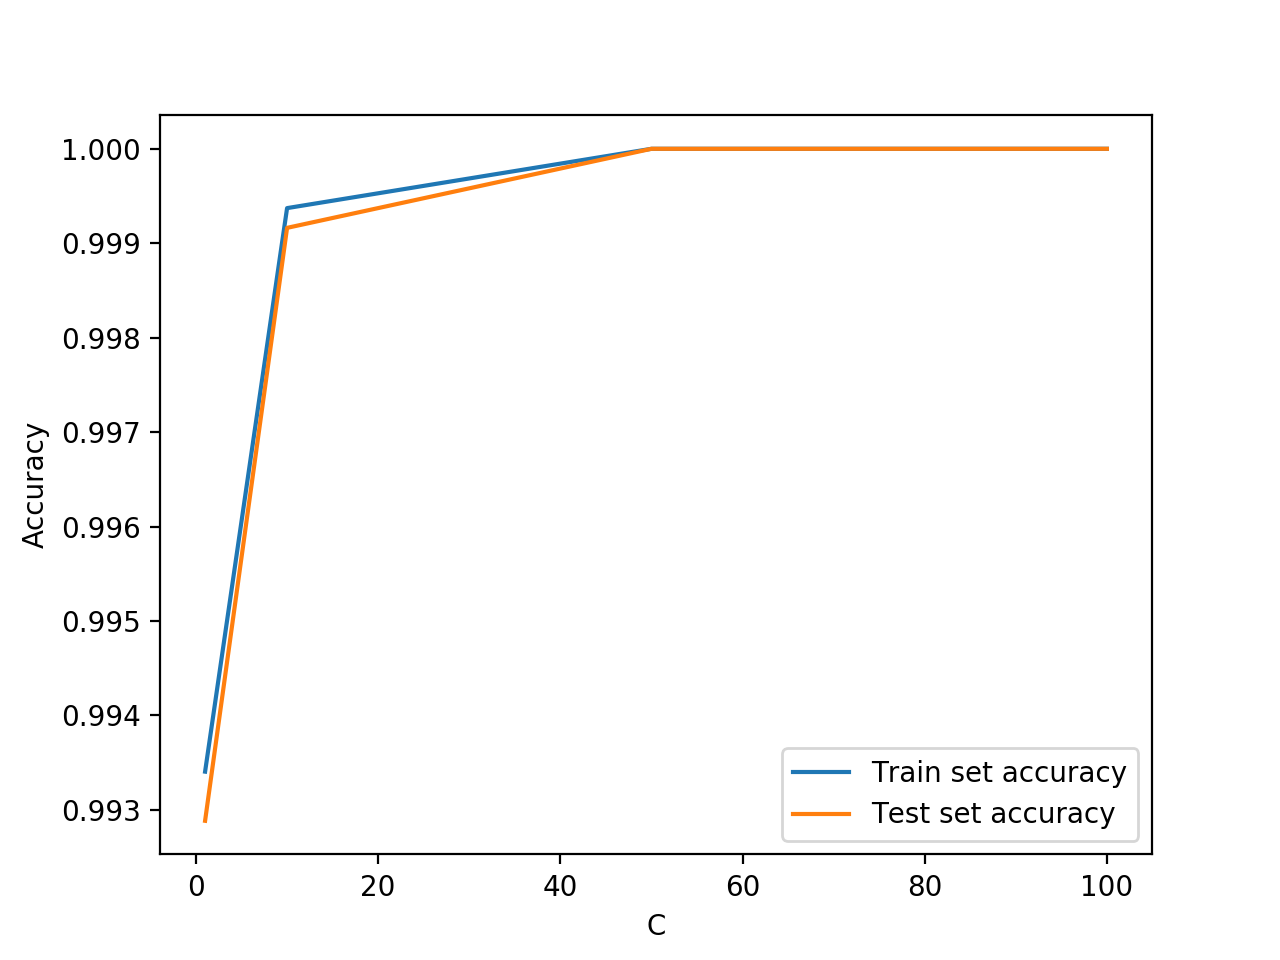

In [90]:
train_accuracy = []
test_accuracy = []

Ci = [1,10, 50, 100]

for i in Ci:
    svm = SVC(C = i, kernel = 'rbf', gamma = 0.001) # try rbf, linear and poly
    svm.fit(X_train, y_train)
    train_accuracy.append(svm.score(X_train, y_train))
    test_accuracy.append(svm.score(X_test, y_test))
figure3 = plt.plot(Ci, train_accuracy, label = 'Train set accuracy')
figure4 = plt.plot(Ci, test_accuracy, label = 'Test set accuracy')
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.legend()
plt.show()

In [105]:
fig1 = [figure3, figure4]
with open('figure2.pickle', 'wb') as figure2:
    pickle.dump(fig1 , figure2)

In [106]:
with open('figure2.pickle', 'rb') as figures2:
    
    figs2 = pickle.load(figures2)
    
figs2


[[<matplotlib.lines.Line2D at 0x7f34afd42048>],

# Merging two datasets 

In this section we will add information from another dataset. This dataset contains all the adress in Washington DC. Since the crime dataset does not contain information when there was no crime, we need a way to add the location when no crime happened.

In [127]:
df1 = data[['latitude', 'longitude', 'ucrrank']] # selecting the relevant labels from the wrangled crime dataset (df).

Since here there are no missing values, we can use the whole rows from the crime dataset. 

In [128]:
# ingesting new dataset
ingest2 = Ingestion('Address_Points.csv', sep = ',', header = 0)
data2 = ingest2.file_csv()

In [129]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147181 entries, 0 to 147180
Data columns (total 52 columns):
X                             147181 non-null float64
Y                             147181 non-null float64
OBJECTID_12                   147181 non-null int64
SITE_ADDRESS_PK               147181 non-null int64
ADDRESS_ID                    147181 non-null int64
STATUS                        147181 non-null object
SSL                           146816 non-null object
TYPE_                         147181 non-null object
ENTRANCETYPE                  147181 non-null object
ADDRNUM                       145278 non-null float64
ADDRNUMSUFFIX                 2258 non-null object
STNAME                        147181 non-null object
STREET_TYPE                   147181 non-null object
QUADRANT                      147181 non-null object
CITY                          147181 non-null object
STATE                         147181 non-null object
FULLADDRESS                   145278 non-nu

### Selecting relevant columns and transforming labels into lowercase for standarization:

In [130]:
df2 = data2[['LATITUDE', 'LONGITUDE']] # selecting the relevant columns. 

df2.columns = df2.columns.str.lower() # transforming labels to lowercase

df2.head(5)


,latitude,longitude
0,38.893995,-76.959322
1,38.894594,-76.959040
2,38.890435,-76.959859
3,38.894384,-76.956349
4,38.894297,-76.956807


In [131]:
df1 = data[['latitude', 'longitude', 'ucrrank']] # selecting the relevant labels from the wrangled crime dataset (df).
df1.ucrrank.describe()

count    69204.000000
mean         6.052829
std          1.300921
min          1.000000
25%          6.000000
50%          6.000000
75%          7.000000
max          9.000000
Name: ucrrank, dtype: float64

In [132]:
Wrangled2 = Wrangling(df2)
# Wrangled.dropNA()
df2 = Wrangled2.lat_long_rounder()

/home/franco/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/franco/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Before merging. In the Adress_point dataset, we need a way to eliminate all the rows from the locations that match the crime dataset.

In [133]:
lat = []
long = []


for i, j, k, l  in zip(df1['latitude'], df2['latitude'], df1['longitude'], df2['longitude']):
    if str(j) in str(i) and str(l) in str(k):
        lat.append(j)
        long.append(l)
        



This means that we only have 27 blocks when no crime ocurred in Washington DC during the last 2 years.
It would be interesting to see where are those blocks:


In [134]:
# Creating the new dataframe:


second_dataframe = {'latitude': lat, 'longitude': long}
second_dataframe = pd.DataFrame(second_dataframe)
second_dataframe['ucrrank'] = 10
second_dataframe

,latitude,longitude,ucrrank
0,38.950,-76.994,10
1,38.820,-77.010,10
2,38.900,-77.000,10
3,38.900,-77.000,10
4,38.900,-77.024,10
5,38.877,-77.000,10
6,38.900,-77.000,10
7,38.922,-76.990,10
8,38.894,-76.957,10
9,38.900,-77.000,10


In [135]:
frames = [df1, second_dataframe]
df_merged = pd.concat(frames, sort = False)
df_merged.head(5)

,latitude,longitude,ucrrank
0,38.886395,-76.955521,8
1,38.902585,-77.059614,6
2,38.900735,-76.981924,6
3,38.910674,-76.937531,4
4,38.905024,-76.995538,4


In [149]:
merged = df_merged
with open('file6.pickle', 'wb') as file6:
    pickle.dump(merged , file6)

In [ ]:
with open('file6.pickle', 'rb') as file_6:
    
    merg = pickle.load(file_6)
    
merg


### Performing predictions the new dataset:


In [136]:
X = df_merged.drop(columns = ['ucrrank'])

y = df_merged['ucrrank']

no need to encode the labels in this case... no categorical variables:

Creating the Training and test set:

In [139]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 0)

Scaling the features:

In [141]:
scaler = StandardScaler()
#scaler =  MinMaxScaler()
#scaler = Normalizer()
X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.fit(X_test).transform(X_test)

Transforming to numpy array to increase performance:

In [143]:
y_test = y_test.values
y_train = y_train.values

#### Performing simple Knn on merged dataset

In [144]:
knn = KNeighborsClassifier(n_neighbors = 10, metric = 'manhattan', weights = 'uniform', algorithm = 'auto')
knn.fit(X_train, y_train)
predicted_knn = knn.predict(X_test)
print("Predictions: {}".format(predicted_knn))

Predictions: [6 7 7 ... 6 7 6]


In [145]:
scores = cross_val_score(knn, X = X_train, y = y_train)
print ("Cross Validation Scores: {}".format(scores))

Cross Validation Scores: [0.50834055 0.50861228 0.51045617]


In [146]:
report = classification_report(y_test, predicted_knn)
print (report)

             precision    recall  f1-score   support

          1       0.00      0.00      0.00        54
          2       0.09      0.01      0.01       131
          3       0.20      0.16      0.17       810
          4       0.15      0.06      0.08       997
          5       0.17      0.05      0.08       698
          6       0.55      0.69      0.61      5683
          7       0.49      0.58      0.53      4449
          8       0.21      0.05      0.08      1019
         10       0.00      0.00      0.00         6

avg / total       0.43      0.49      0.45     13847



#### Finding the best parameters for Knn on merged dataset:

In [151]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

params2 = [{'n_neighbors': [1,10,50,100], 'algorithm': ['auto','ball_tree','kd_tree' ], 
            'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'manhattan']}]
            
grid_search = GridSearchCV(estimator = knn, param_grid = params2, scoring = 'accuracy', cv = 5, n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
accuracy = grid_search.best_score_
best_params = grid_search.best_params_

In [152]:
print(accuracy)
print(best_params)

0.5144265491838799
{'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'uniform'}


In [155]:
knn_merged = [grid_search, accuracy, best_params]
with open('file7.pickle', 'wb') as file7:
    pickle.dump(knn_merged , file7)

In [ ]:
with open('file7.pickle', 'rb') as file_7:
    
    knnmerg = pickle.load(file_7)
    
knnmerg

#### Kernel SVC on merged dataset:

In [157]:

svm = SVC(C = 10, kernel = 'rbf', gamma = 0.1)
svm.fit(X_train, y_train)
predicted = svm.predict(X_test)

#print("Predictions: {}".format(predicted))

scores = cross_val_score(svm, X = X_train, y = y_train)
report = classification_report(y_test, predicted)
print (report)

# print ("Cross Validation Scores: {}".format(scores))

             precision    recall  f1-score   support

          1       0.00      0.00      0.00        54
          2       0.00      0.00      0.00       131
          3       0.00      0.00      0.00       810
          4       0.00      0.00      0.00       997
          5       0.00      0.00      0.00       698
          6       0.42      0.92      0.57      5683
          7       0.38      0.11      0.17      4449
          8       0.00      0.00      0.00      1019
         10       0.00      0.00      0.00         6

avg / total       0.29      0.41      0.29     13847



/home/franco/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [158]:
svc_merged = [predicted, scores, report]
with open('file8.pickle', 'wb') as file8:
    pickle.dump(svc_merged , file8)

In [ ]:
with open('file8.pickle', 'rb') as file_8:
    
    svcmerg = pickle.load(file_8)
    
svcmerg

#### Finding the best parameters for Kernel SVC on merged dataset:

In [160]:
params = [{'C': [1, 10, 30, 100], 'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 0.001]}]
     
                          
grid_search = GridSearchCV(estimator = svm, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
accuracySVC = grid_search.best_score_
best_paramsSVC = grid_search.best_params_

In [161]:
print(accuracySVC)
print(best_paramsSVC)

0.45464394048822765
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}


In [162]:
svc_merged2 = [predicted, scores, report]
with open('file9.pickle', 'wb') as file9:
    pickle.dump(svc_merged , file9)

In [ ]:
with open('file9.pickle', 'rb') as file_9:
    
    svcmerg2 = pickle.load(file_9)
    
svcmerg2

#### Multilayer Perceptron test on merged dataset

In [172]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(200,), random_state=1, max_iter = 200)

In [173]:
clf.fit(X_train, y_train)  

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [174]:
predicted = clf.predict(X_test)

In [175]:
report = classification_report(y_test, predicted)
print (report)

             precision    recall  f1-score   support

          1       0.00      0.00      0.00        54
          2       0.00      0.00      0.00       131
          3       0.00      0.00      0.00       810
          4       0.00      0.00      0.00       997
          5       0.00      0.00      0.00       698
          6       0.46      0.74      0.57      5683
          7       0.46      0.48      0.47      4449
          8       0.00      0.00      0.00      1019
         10       0.00      0.00      0.00         6

avg / total       0.34      0.46      0.38     13847



/home/franco/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The score it lower than using the traditional models. It will be worth triying more layers and iteration if the computation power allows it.

In [176]:
mlp = [predicted, report]
with open('file10.pickle', 'wb') as file10:
    pickle.dump(mlp , file10)

In [ ]:
with open('file10.pickle', 'rb') as file_10:
    
    Mlp = pickle.load(file_10)
    
Mlp

# Other models:

In [178]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth= None, min_samples_split = 2, random_state=0, criterion='entropy')

clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [179]:
predicted = clf.predict(X_test)
report = classification_report(y_test, predicted)
print (report)

             precision    recall  f1-score   support

          1       0.00      0.00      0.00        54
          2       0.00      0.00      0.00       131
          3       0.19      0.09      0.12       810
          4       0.17      0.05      0.08       997
          5       0.10      0.03      0.05       698
          6       0.53      0.56      0.54      5683
          7       0.44      0.62      0.51      4449
          8       0.13      0.07      0.09      1019
         10       0.00      0.00      0.00         6

avg / total       0.40      0.44      0.41     13847



Knn and Random forest classifier reported the highest accuracy. This dataset contains only 2 independent features:
Latitude and longitude. This indicates that there are more features tha directly influence the dependent variable:

# User Friendly Version:

This analysis will try to predict the most likely crime based on features that are easy to understand and user friendly:

We will start by selecting those features from the crime dataset:

In [182]:
df_friendly = df[['latitude', 'longitude', 'shift', 'year', 'month', 'day', 'hour', 'minute', 'street', 'startblock', 'endblock', 'ucrrank']]

In [183]:
X = df_friendly.drop(columns = ['ucrrank'])

y = df_friendly['ucrrank']

### Encoding the Categorical variables: 

In [184]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder() # it only support one dimentional columns.. 

for colname,col in X.iteritems(): # adapted from stack overflow
    if col is not float:
        X[colname] = LabelEncoder().fit_transform(col)

### Studying  the importance of the features :


In [185]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10) # input a number for feature extraction

features = X

X_ = pca.fit_transform(features)

explained_var = pca.explained_variance_ratio_
explained_var


array([5.57595542e-01, 2.85784823e-01, 7.69789235e-02, 3.37929389e-02,
       3.02679114e-02, 6.66007223e-03, 4.75848134e-03, 3.07430069e-03,
       1.01525327e-03, 4.23301169e-05])

<IPython.core.display.Javascript object>


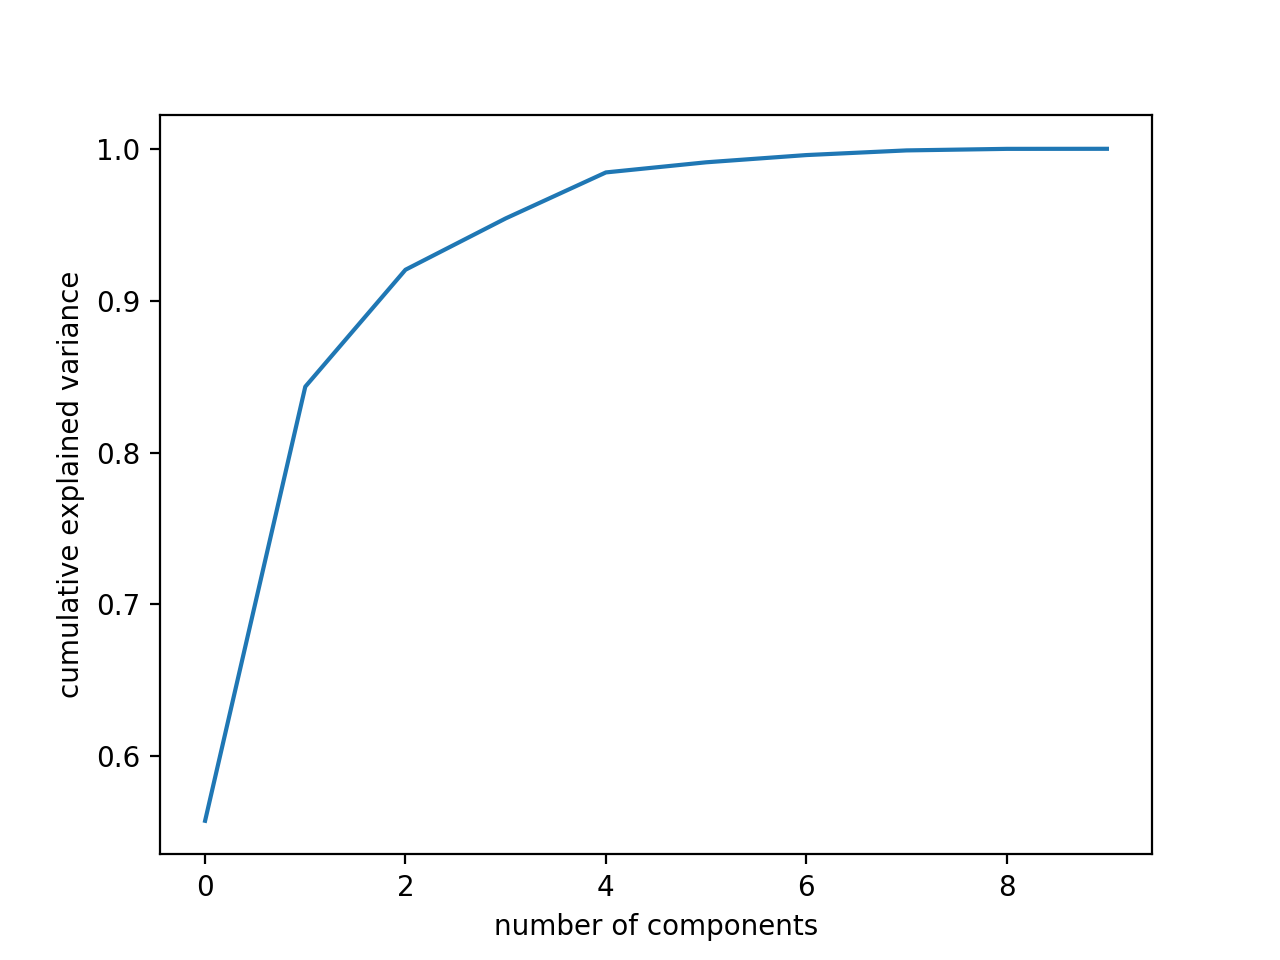

In [186]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Creating the Training and test set:

In [187]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 0)

### Standarization of the dataset:

In [188]:
scaler = StandardScaler()
#scaler =  MinMaxScaler()
#scaler = Normalizer()
X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.fit(X_test).transform(X_test)

In [189]:
y_train = y_train.values
y_test = y_test.values


### KNN(User Friendly Version):

In [190]:
knn = KNeighborsClassifier(n_neighbors = 10, metric = 'manhattan', weights = 'uniform', algorithm = 'auto')
knn.fit(X_train, y_train)
predicted_knn = knn.predict(X_test)
print("Predictions: {}".format(predicted_knn))

Predictions: [6 6 6 ... 6 6 6]


Cross Validation:

In [191]:
scores = cross_val_score(knn, X = X_train, y = y_train)
print ("Cross Validation Scores: {}".format(scores))

Cross Validation Scores: [0.63151287 0.63002513 0.64047769]


In [192]:
report = classification_report(y_test, predicted_knn)
print (report)

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.00      0.00      0.00        15
          3       0.11      0.04      0.06        77
          4       0.09      0.02      0.03       103
          5       0.17      0.01      0.03        70
          6       0.65      0.92      0.76      1438
          7       0.51      0.25      0.34       591
          8       1.00      0.01      0.02        93

avg / total       0.57      0.62      0.55      2389



/home/franco/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<IPython.core.display.Javascript object>


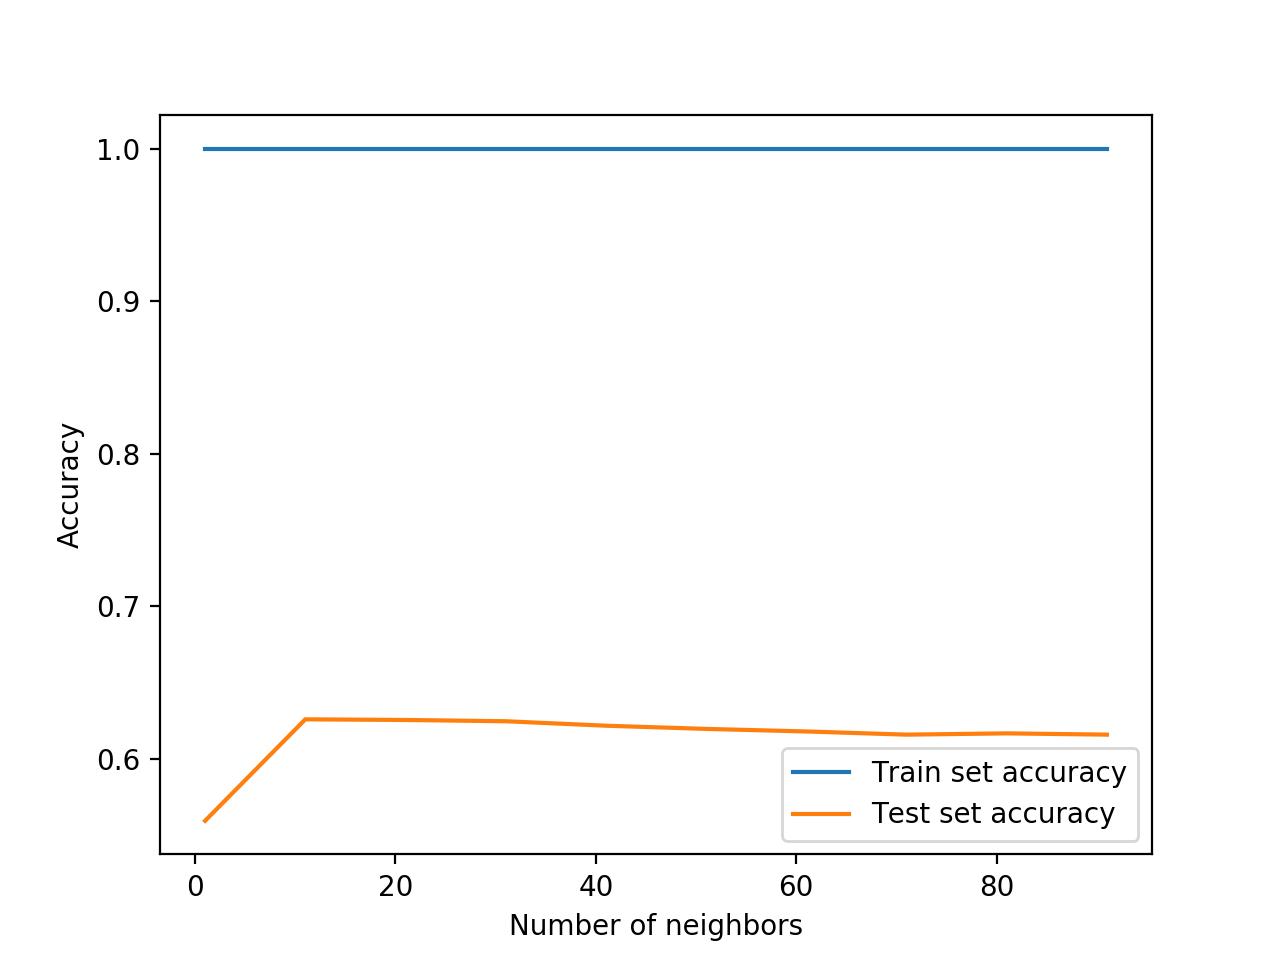

In [193]:
train_accuracy = []
test_accuracy = []

neighbors = range(1,100,10)
algorithms = ['auto', 'ball_tree', 'kd_tree']
weights = ['uniform', 'distance']

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors = i, metric = 'manhattan', weights = 'distance', algorithm = 'auto')
    knn.fit(X_train, y_train)
    train_accuracy.append(knn.score(X_train, y_train))
    test_accuracy.append(knn.score(X_test, y_test))
figure1 = plt.plot(neighbors, train_accuracy, label = 'Train set accuracy')
figure2 = plt.plot(neighbors, test_accuracy, label = 'Test set accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Number of neighbors")
plt.legend()
plt.show()

## Kernel SVC(User Friendly Version):

In [194]:
from sklearn.svm import SVC
svm = SVC(C = 1000, kernel = 'rbf', gamma = 1)
svm.fit(X_train, y_train)
predicted = svm.predict(X_test)

#print("Predictions: {}".format(predicted))

scores = cross_val_score(svm, X = X_train, y = y_train)
report = classification_report(y_test, predicted)
print (report)

# print ("Cross Validation Scores: {}".format(scores))

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.00      0.00      0.00        15
          3       0.12      0.04      0.06        77
          4       0.11      0.06      0.08       103
          5       0.20      0.06      0.09        70
          6       0.64      0.84      0.73      1438
          7       0.41      0.27      0.33       591
          8       0.10      0.02      0.04        93

avg / total       0.51      0.58      0.53      2389



/home/franco/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Finding the best parameters for Kernel SVC(User Friendly Version):

In [195]:
params = [{'C': [1, 10, 30, 100], 'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 0.001]}]
     
                          
grid_search = GridSearchCV(estimator = svm, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
accuracySVC = grid_search.best_score_
best_paramsSVC = grid_search.best_params_

In [196]:
print(accuracySVC)
print(best_paramsSVC)

0.6304438860971524
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


There is definetly less accuracy that when using all the features of the dataset. It would be important to discover the meaning of all those features in order to study if those can be used in our user friendly model.

In [197]:
reports_list = [predicted_knn, scores, report, grid_search, accuracySVC, best_paramsSVC]
with open('file11.pickle', 'wb') as file11:
    pickle.dump(mlp , file11)

In [ ]:
with open('file11.pickle', 'rb') as file_11:
    
    rl = pickle.load(file_11)
    
rl